In [1]:
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import DataGenerationDynamic as dgd 
from fleet_greedy_allocationDynamic import greedy_basic,greedy_positionupdate 
from QL_Allocation import QL_without_charger as QL
from Auction_Allocation import auction_without_charger
from Auction_with_Charger import auction_with_charger

np.random.seed(42)
random.seed(42)
os.environ["PL_GLOBAL_SEED"] = str(42)

# Simulation parameters
TIME_STEPS = 100          # Total simulation time steps (each assumed to be 1 minute)
NEW_TASK_PROB = 0.5       # Probability a new task arrives at a time step
URGENCY_INCREMENT = 1     # Urgency increases by this amount each time step


In [2]:
def get_csv_path(num):
    """ 
    Function to get the path of the CSV file to store the data
    """
    if not os.path.exists('vehicle'):
        os.makedirs('vehicle')
    if not os.path.exists('task'):
        os.makedirs('task')
    if not os.path.exists('randomtask'):
        os.makedirs('randomtask')
    csv_path = f'vehicle/vehicle_{num}.csv'
    csv_path_task = f'task/task_{num}.csv'
    csv_path_random_task = f'randomtask/randomtask_{num}.csv'
    return csv_path, csv_path_task, csv_path_random_task

def get_charger(vehicles_df):
    """
    Create Charger DataFrame by using first location of vehicles
    return: Charger DataFrame
    """
    Vehicle_Charger = []
    for idx, vehicle in vehicles_df.iterrows():
        Vehicle_Charger.append({
                    'Charger ID': f"C{idx+1}",
                    'Charger Position (x, y)': vehicle["Vehicle Position (x, y)"],
                    'Available After ': 0,
                    'Busy': False
                })
    Vehicle_Charger=pd.DataFrame(Vehicle_Charger)
    return Vehicle_Charger

def compute_metrics(engagement_metrics, vehicles_df):
    if not engagement_metrics:
        return {}
    num_tasks = len(engagement_metrics)
    total_engagement_time = sum(item["engagement_time"] for item in engagement_metrics)
    avg_engagement_time = total_engagement_time / num_tasks
    avg_normalized_engagement = sum(item["normalized_engagement_time"] for item in engagement_metrics) / num_tasks
    total_task_duration = sum(item["task_duration"] for item in engagement_metrics)
    total_energy_consumed = sum(item["energy_consumed"] for item in engagement_metrics)
    energy_per_unit = total_energy_consumed / total_task_duration if total_task_duration > 0 else None
    throughput = total_task_duration
    total_idle_time = vehicles_df["Idle Time"].sum()
    avg_idle_time = total_idle_time / len(vehicles_df)
    return {
        "num_tasks": num_tasks,                          # Total number of tasks completed
        "avg_engagement_time": avg_engagement_time,        # Average time each task required (including travel)
        "avg_normalized_engagement": avg_normalized_engagement,  # Ratio of (engagement_time / task_duration)
        "energy_per_unit": energy_per_unit,                # Energy consumed per minute of intrinsic task duration
        "throughput": throughput,                          # Total intrinsic task duration completed
        "total_idle_time": total_idle_time,                # Cumulative idle time (min) across all vehicles
        "avg_idle_time": avg_idle_time                     # Average idle time per vehicle (min)
    }


In [ ]:
def compare(num,function: callable):
    """
    Function to compare the strategies
    @param num  the n-th run of the Compare function to Compare the strategies with different task arrival data and vehicle data
    @param function  the algorithm to be compared
    @return metrics_greedy  the metrics of the greedy algorithm
    """
    
    vehicle_csv, task_csv, random_task_csv = get_csv_path(num)
    
    # Try to read the CSV if it exists Compare Strategies 
    try:
        vehicles_df = pd.read_csv(vehicle_csv)
        vehicles_df["Vehicle Position (x, y)"] = vehicles_df["Vehicle Position (x, y)"].apply(eval)
    except:
        # Generate initial vehicles data if file doesn't exist
        vehicles_df = dgd.generate_vehicle_data(10)
        vehicles_df.to_csv(vehicle_csv, index=False)
    Charger_df = get_charger(vehicles_df)
    # Save a copy for greedy method
    vehicles_greedy = vehicles_df.copy()
    
    # Add columns to track vehicle status, remaining duration, and idle time.
    for vehicles in [vehicles_greedy]:
        vehicles['Busy'] = False
        vehicles['Remaining Duration'] = 0  
        vehicles["Battery Level (%)"] = vehicles["Battery Level (%)"].astype(float)
        vehicles["Remaining Duration"] = vehicles["Remaining Duration"].astype(float)
        vehicles["Idle Time"] = 0.0  
        vehicles["Charging"] = False # New column to track charging status
        vehicles["Charger ID"] = None # New column to track charger ID

    # Try to read the CSV if it exists to Compare Strategies    
    try:
        initial_tasks = pd.read_csv(task_csv)
        initial_tasks["Task Position (x, y)"] = initial_tasks["Task Position (x, y)"].apply(eval)
    except:
        initial_tasks = dgd.generate_task_data(num_tasks=10)
        initial_tasks.to_csv(task_csv, index=False)

    tasks_waiting_greedy = initial_tasks.to_dict('records')

    # Dictionary to hold the cumulative allocations for greedy.
    allocations_greedy = {}

    # List to hold engagement details (for computing metrics).
    engagement_metrics_greedy = []

    task_counter = 1

    # Simulation loop
    for t in range(TIME_STEPS):
        # print(f"\nTime step: {t}")
        
        # --- Update busy vehicles & idle time ---
        for vehicles in [vehicles_greedy]:
            for idx, vehicle in vehicles.iterrows():
                if vehicle['Busy']:
                    new_duration = vehicle['Remaining Duration'] - 1
                    vehicles.at[idx, 'Remaining Duration'] = new_duration
                    if new_duration <= 0:
                        vehicles.at[idx, 'Busy'] = False
                        vehicles.at[idx, 'Remaining Duration'] = 0
                else:
                    vehicles.at[idx, 'Idle Time'] = float(vehicle['Idle Time']) + 1

        # --- Update charging vehicles & idle time ---
        for vehicles in [vehicles_greedy]:
            for idx, vehicle in vehicles.iterrows():
                if vehicle['Charging']:
                    new_duration = vehicle['Remaining Duration'] - 1
                    new_avaliable = Charger_df.at[vehicle['Charger ID'], 'Available After ']-1
                    vehicles.at[idx, 'Idle Time'] = float(vehicle['Idle Time']) + 1
                    vehicles.at[idx, 'Remaining Duration'] = new_duration
                    Charger_df.at[vehicle['Charger ID'], 'Available After '] = new_avaliable
                    
                    if new_duration <= 0:
                        vehicles.at[idx, 'Battery Level (%)'] = vehicles.at[idx, 'Battery Level (%)'] + 1
                        if Charger_df.at[vehicle['Charger ID'], 'Available After '] == 0:
                            cid=vehicles.at[idx, 'Charger ID']
                            vehicles.at[idx, 'Charging'] = False
                            vehicles.at[idx, 'Remaining Duration'] = 0
                            vehicles.at[idx, 'Battery Level (%)'] = 100
                            vehicles.at[idx, 'Busy'] = False
                            vehicles.at[idx, 'Charger ID'] = None
                            vehicles.at[idx, 'Charger Position (x, y)'] = None
                            Charger_df.at[cid, 'Available After '] = 0
                            Charger_df.at[cid, 'Busy'] = False
                            
        # --- Increase urgency for waiting tasks ---
        for task in tasks_waiting_greedy:
            task['Urgency'] += URGENCY_INCREMENT
        # --- Dynamic task arrival --- Loading from the CSV file to Compare Strategies
        try:
            with open(random_task_csv, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    new_task = {
                        'Task ID': parts[1],
                        'Task Position (x, y)': (int(parts[2]), int(parts[3])),
                        'Urgency': int(parts[4]),
                        'Duration (min)': int(parts[5])
                    }
                
                    if t == int(parts[0]):

                        tasks_waiting_greedy.append(new_task.copy()) 
        except:
            
            if random.random() < NEW_TASK_PROB:
                new_task = {
                    'Task ID': f"D{task_counter}", 
                    'Task Position (x, y)': (random.randint(0, 100), random.randint(0, 100)),
                    'Urgency': random.randint(0, 9),
                    'Duration (min)': random.randint(10, 30)
                }
                # print("New dynamic task created:", new_task)
                task_counter += 1
                tasks_waiting_greedy.append(new_task.copy())
                new_tasks = pd.DataFrame(tasks_waiting_greedy)
                new_tasks.to_csv(random_task_csv, index=False)

        # --- Process waiting tasks using Greedy ---
        if tasks_waiting_greedy:
            tasks_df_greedy = pd.DataFrame(tasks_waiting_greedy)
            if "with_charger" in function.__name__ :
                alloc_g, details_g = function(vehicles_greedy, tasks_df_greedy,Charger_df)
            else:
                alloc_g, details_g = function(vehicles_greedy, tasks_df_greedy)
            allocations_greedy.update(alloc_g)
            engagement_metrics_greedy.extend(details_g)
            allocated_ids = set(alloc_g.keys())
            tasks_waiting_greedy = [task for task in tasks_waiting_greedy if task['Task ID'] not in allocated_ids]

    metrics_greedy = compute_metrics(engagement_metrics_greedy, vehicles_greedy)
    return metrics_greedy

FIGURE 1

C:\Users\Sepeh\AppData\Local\Temp\ipykernel_1556\3976822425.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


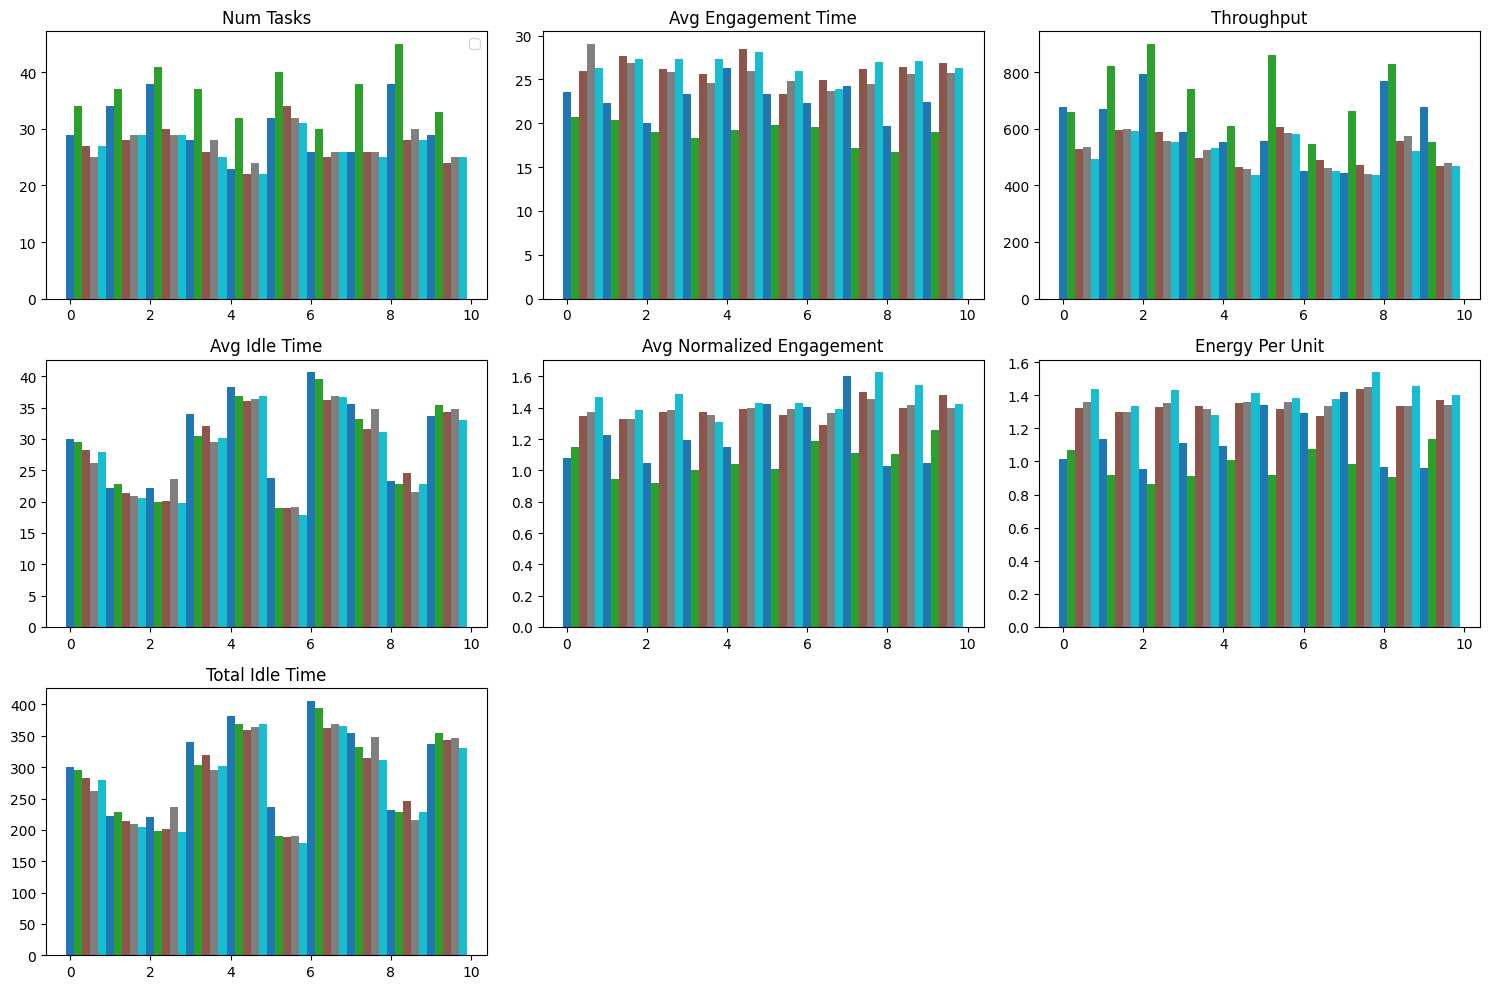


Average Metrics:
                         num_tasks  avg_engagement_time  \
auction_with_charger          30.3            22.763990   
auction_without_charger       36.7            19.007708   
greedy_basic                  27.0            26.173211   
greedy_positionupdate         27.4            25.689081   
QL_without_charger            26.7            26.646794   

                         avg_normalized_engagement  energy_per_unit  \
auction_with_charger                      1.221320         1.129404   
auction_without_charger                   1.071907         0.980856   
greedy_basic                              1.384316         1.337418   
greedy_positionupdate                     1.387548         1.351017   
QL_without_charger                        1.450888         1.405591   

                         throughput  total_idle_time  avg_idle_time  
auction_with_charger          617.8            303.2          30.32  
auction_without_charger       718.1            289.4        

In [ ]:
# List of strategies to compare
compare_list = [auction_with_charger,auction_without_charger, greedy_basic, greedy_positionupdate,QL]

# a dictionary to store metrics for each strategy
all_metrics = {func.__name__: [] for func in compare_list}

# Collect metrics for all strategies
for i in compare_list:
    for j in range(10):
        metrics = compare(j+1, i)
        all_metrics[i.__name__].append(metrics)

# Calculate average metrics for each strategy
avg_metrics = pd.DataFrame()
for strategy_name, metrics_list in all_metrics.items():
    avg_metrics[strategy_name] = pd.DataFrame(metrics_list).mean()

# Plotting all strategies together
plt.figure(figsize=(15, 10))

# Get metrics to plot
metrics_to_plot = ['num_tasks', 'avg_engagement_time', 'throughput', 'avg_idle_time',
                   'avg_normalized_engagement', 'energy_per_unit', 'total_idle_time']

# Define colors for j = 0
colors = plt.get_cmap('tab10', len(compare_list))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(3, 3, i+1)

    # Extract data for this metric across all strategies
    for idx, strategy in enumerate(all_metrics.keys()):
        values = [m[metric] for m in all_metrics[strategy] if metric in m]
        
        plt.bar([j + idx * 0.2 for j in range(len(values))], values, width=0.2, label=strategy if j == 0 else "", color=colors(idx))

    plt.title(metric.replace('_', ' ').title())
    if i == 0:  # Only add legend to the first subplot
        plt.legend()

plt.tight_layout()
plt.show()

# Print average metrics
print("\nAverage Metrics:")
print(avg_metrics.T)  # Transposed for better readability
print("\n")
# auction_with_charger --> Blue bar plot
# auction_without_charger --> green bar plot
# greedy_basic --> Browns bar plot
# greedy_positionupdate --> gray bar plot
# QL --> Blue sky bar plot

FIGURE 2

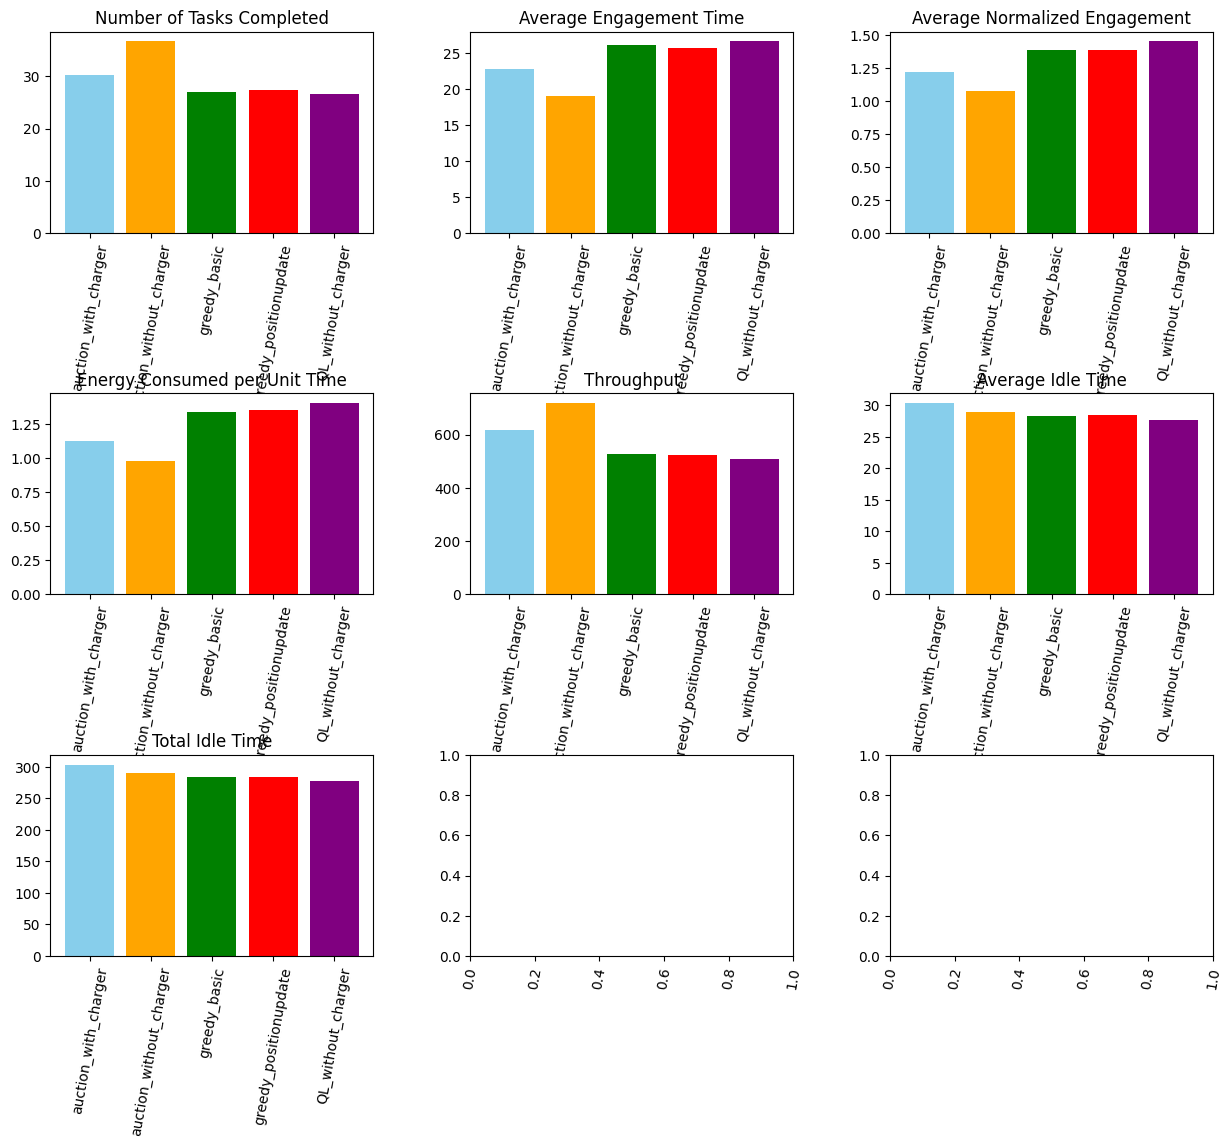

In [5]:
# Plotting the average metrics for each strategy
colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs[0, 0].bar(avg_metrics.columns, avg_metrics.loc['num_tasks'], color=colors)
axs[0, 0].set_title('Number of Tasks Completed')
axs[0, 1].bar(avg_metrics.columns, avg_metrics.loc['avg_engagement_time'],color=colors)
axs[0, 1].set_title('Average Engagement Time')
axs[0, 2].bar(avg_metrics.columns, avg_metrics.loc['avg_normalized_engagement'],color=colors)
axs[0, 2].set_title('Average Normalized Engagement')
axs[1, 0].bar(avg_metrics.columns, avg_metrics.loc['energy_per_unit'],color=colors)
axs[1, 0].set_title('Energy Consumed per Unit Time')
axs[1, 1].bar(avg_metrics.columns, avg_metrics.loc['throughput'], color=colors)
axs[1, 1].set_title('Throughput')
axs[1, 2].bar(avg_metrics.columns, avg_metrics.loc['avg_idle_time'],color=colors)
axs[1, 2].set_title('Average Idle Time')
axs[2, 0].bar(avg_metrics.columns, avg_metrics.loc['total_idle_time'],color=colors)
axs[2, 0].set_title('Total Idle Time')
for ax in axs.flat:
    plt.sca(ax)
    plt.xticks(rotation=80)
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.show()